# GRU Model cho Email Phishing Detection

Notebook này thực hiện:
1. Load và chuẩn bị dữ liệu train/validation/test (70-15-15 split)
2. Trích xuất đặc trưng từ text bằng TextVectorization
3. Xây dựng và train mô hình GRU (Gated Recurrent Unit)
4. Đánh giá model trên cả 3 tập dữ liệu
5. Tính toán và visualize các metrics: accuracy, precision, recall, F1-score, AUC-ROC
6. Lưu model, vocabulary và kết quả đánh giá

## Kiến trúc Model:
- **Input**: Text email (string)
- **TextVectorization**: Chuyển text thành sequences (max_tokens=20000, sequence_length=512)
- **Embedding**: 128 dimensions
- **GRU Layer**: 64 units
- **Dense Layer**: 64 units với ReLU activation
- **Output**: 1 neuron với sigmoid activation (binary classification)


## 1. Setup và Mount Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Import Thư Viện


In [2]:
# Import các thư viện cần thiết

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# Metrics và evaluation
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_recall_fscore_support,
    classification_report, precision_score, recall_score,
    roc_curve, auc, roc_auc_score
)

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Utilities
import json
import random
import os
import io

## 3. Cấu Hình Đường Dẫn


In [ ]:
# Cấu hình đường dẫn

BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/Graduation-Project'

# Tạo thư mục output nếu chưa tồn tại
os.makedirs(f'{BASE_PATH}/outputs/models/GRU', exist_ok=True)
os.makedirs(f'{BASE_PATH}/outputs/models/GRU/logs', exist_ok=True)
os.makedirs(f'{BASE_PATH}/outputs/models/GRU/checkpoints', exist_ok=True)

print(f"Working directory: {BASE_PATH}")

Working directory: /content/drive/MyDrive/Colab Notebooks/DL-in-detecting-email-with-fake-content


## 4. Load Dữ Liệu

Dữ liệu đã được chia sẵn thành train/validation/test (70-15-15) từ notebook `analyze_and_imbalance_processing.ipynb`


In [4]:
# Load dữ liệu train, validation và test (70-15-15)

df_train = pd.read_csv(f'{BASE_PATH}/data/final/final_train.csv')
df_val = pd.read_csv(f'{BASE_PATH}/data/final/final_val.csv')
df_test = pd.read_csv(f'{BASE_PATH}/data/final/final_test.csv')

print("-"*50)
print("Đã load dữ liệu")
print(f"Train: {len(df_train)} samples")
print(f"Validation: {len(df_val)} samples")
print(f"Test: {len(df_test)} samples")

--------------------------------------------------
Đã load dữ liệu
Train: 13648 samples
Validation: 2925 samples
Test: 2925 samples


In [5]:
# Chuẩn bị dữ liệu train

X_train = df_train['text']
y_train = df_train['label']

# Chuẩn bị dữ liệu validation
X_val = df_val['text']
y_val = df_val['label']

# Chuẩn bị dữ liệu test
X_test = df_test['text']
y_test = df_test['label']

print("-"*50)
print("Đã chuẩn bị dữ liệu")
print(f"X_train: {len(X_train)} samples")
print(f"X_val: {len(X_val)} samples")
print(f"X_test: {len(X_test)} samples")

--------------------------------------------------
Đã chuẩn bị dữ liệu
X_train: 13648 samples
X_val: 2925 samples
X_test: 2925 samples


## 5. Khám Phá Dữ Liệu


In [6]:
print("Thông tin dataset")

# Dataset train
print("-"*50)
print("\n[Train dataset]")
print(f"Tổng số samples: {len(X_train)}")
print(f"Phân phối label:")
print(y_train.value_counts())
print(f"Tỷ lệ:")
print(y_train.value_counts(normalize=True).map('{:.2%}'.format))

# Dataset validation
print("-"*50)
print("\n[Validation dataset]")
print(f"Tổng số samples: {len(X_val)}")
print(f"Phân phối label:")
print(y_val.value_counts())
print(f"Tỷ lệ:")
print(y_val.value_counts(normalize=True).map('{:.2%}'.format))

# Dataset test
print("-"*50)
print("\n[Test dataset]")
print(f"Tổng số samples: {len(X_test)}")
print(f"Phân phối label:")
print(y_test.value_counts())
print(f"Tỷ lệ:")
print(y_test.value_counts(normalize=True).map('{:.2%}'.format))

Thông tin dataset
--------------------------------------------------

[Train dataset]
Tổng số samples: 13648
Phân phối label:
label
0    6998
1    6650
Name: count, dtype: int64
Tỷ lệ:
label
0    51.27%
1    48.73%
Name: proportion, dtype: object
--------------------------------------------------

[Validation dataset]
Tổng số samples: 2925
Phân phối label:
label
0    1500
1    1425
Name: count, dtype: int64
Tỷ lệ:
label
0    51.28%
1    48.72%
Name: proportion, dtype: object
--------------------------------------------------

[Test dataset]
Tổng số samples: 2925
Phân phối label:
label
0    1500
1    1425
Name: count, dtype: int64
Tỷ lệ:
label
0    51.28%
1    48.72%
Name: proportion, dtype: object


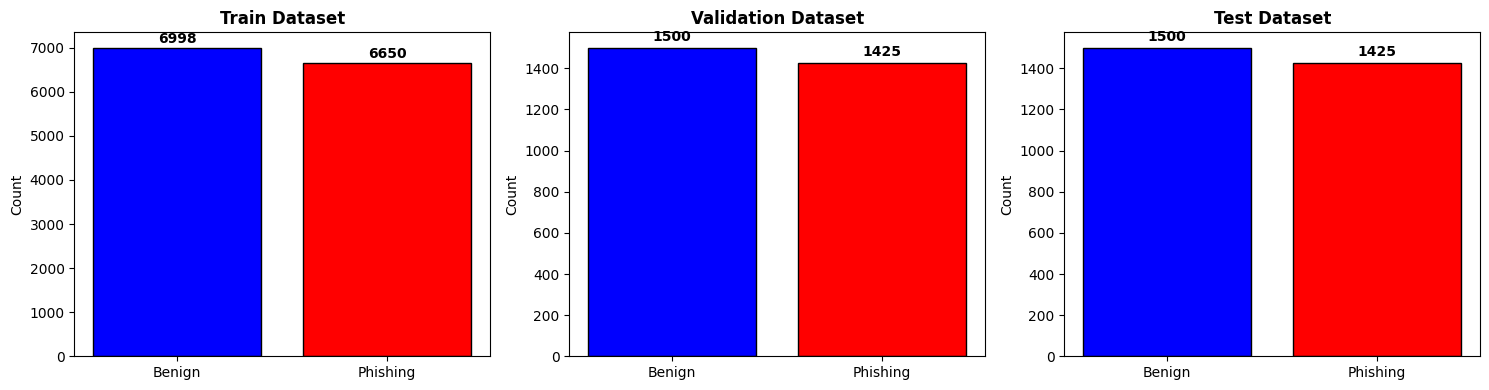

In [7]:
# Visualization phân phối dữ liệu
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Train
train_counts = y_train.value_counts().values
axes[0].bar(['Benign', 'Phishing'], train_counts, color=['blue', 'red'], edgecolor='black')
axes[0].set_title('Train Dataset', fontweight='bold')
axes[0].set_ylabel('Count')
for i, count in enumerate(train_counts):
    axes[0].text(i, count + 50, str(count), ha='center', va='bottom', fontweight='bold')

# Validation
val_counts = y_val.value_counts().values
axes[1].bar(['Benign', 'Phishing'], val_counts, color=['blue', 'red'], edgecolor='black')
axes[1].set_title('Validation Dataset', fontweight='bold')
axes[1].set_ylabel('Count')
for i, count in enumerate(val_counts):
    axes[1].text(i, count + 20, str(count), ha='center', va='bottom', fontweight='bold')

# Test
test_counts = y_test.value_counts().values
axes[2].bar(['Benign', 'Phishing'], test_counts, color=['blue', 'red'], edgecolor='black')
axes[2].set_title('Test Dataset', fontweight='bold')
axes[2].set_ylabel('Count')
for i, count in enumerate(test_counts):
    axes[2].text(i, count + 20, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Phân Tích Độ Dài Text

Phân tích độ dài của các email để quyết định `output_sequence_length` cho TextVectorization


In [8]:
# Tính độ dài (số từ) của mỗi email trong training data

text_length = []
for text in X_train:
    text_length.append(len(str(text).split(' ')))

print("-"*50)
print("Phân tích độ dài texttext")
print(f"Email dài nhất: {max(text_length)} từ")
print(f"Email ngắn nhất: {min(text_length)} từ")
print(f"Độ dài trung bình: {np.mean(text_length):.1f} từ")
print(f"Độ dài trung vị: {np.median(text_length):.1f} từ")

# Tìm độ dài mà 95% email nhỏ hơn
percentile_95 = round(np.percentile(text_length, 95))
print(f"\n95% email có độ dài < {percentile_95} từ")
print(f"Chọn output_sequence_length = 512")

--------------------------------------------------
Phân tích độ dài texttext
Email dài nhất: 554 từ
Email ngắn nhất: 1 từ
Độ dài trung bình: 210.1 từ
Độ dài trung vị: 182.0 từ

95% email có độ dài < 467 từ
Chọn output_sequence_length = 512


## 7. Định Nghĩa Helper Functions


In [9]:
# Helper functions - tính toán metrics

def calculate_results(y_true, y_pred):
    """
    Tính toán accuracy, precision, recall và f1-score cho binary classification.

    Args:
        y_true: True labels (1D array)
        y_pred: Predicted labels (1D array)

    Returns:
        dict: Dictionary chứa accuracy, precision, recall, f1-score
    """
    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted"
    )
    return {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }


def calculate_metrics(y_true, y_pred):
    """
    Tính toán các metrics bổ sung: fdr, fnr, for, fpr, npv.

    Args:
        y_true: True labels (1D array)
        y_pred: Predicted labels (1D array)

    Returns:
        dict: Dictionary chứa các metrics bổ sung
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        'False Discovery Rate (FDR)': fp / (tp + fp) if (tp + fp) != 0 else 0,
        'False Negative Rate (FNR)': fn / (tp + fn) if (tp + fn) != 0 else 0,
        'False Omission Rate (FOR)': fn / (fn + tn) if (fn + tn) != 0 else 0,
        'False Positive Rate (FPR)': fp / (fp + tn) if (fp + tn) != 0 else 0,
        'Negative Prediction Value (NPV)': tn / (tn + fn) if (tn + fn) != 0 else 0
    }

In [10]:
# Helper function - visualization

def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray,
                         class_names: list = ["Benign", "Phishing"],
                         title: str = "Confusion Matrix",
                         save_path: str = None) -> None:
    """
    Vẽ confusion matrix cho binary classification.

    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_names: Tên các class
        title: Tiêu đề của plot
        save_path: Đường dẫn để lưu file (optional)
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved confusion matrix to: {save_path}")

    plt.show()


def plot_roc_curve(y_true: np.ndarray, y_probs: np.ndarray,
                   set_name: str = "Dataset", save_path: str = None):
    """
    Vẽ roc curve và tính auc score.

    Args:
        y_true: True labels
        y_probs: Predicted probabilities (chưa chuyển thành binary)
        set_name: Tên dataset (train/validation/test)
        save_path: Đường dẫn để lưu file (optional)

    Returns:
        tuple: (auc_score, fpr, tpr)
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
             label='Random Classifier (AUC = 0.5000)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    plt.title(f'ROC Curve - {set_name} Set', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved ROC curve to: {save_path}")

    plt.show()

    return auc_score, fpr, tpr


def plot_loss_and_accuracy_curves(model_history):
    """
    Vẽ training và validation loss/accuracy curves.

    Args:
        model_history: History object từ model.fit()
    """
    epochs = range(len(model_history.history['loss']))
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']

    plt.figure(figsize=(14, 5))

    # Vẽ loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, 'b', label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=13, fontweight='bold')
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Loss', fontsize=11)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Vẽ accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r', label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy', linewidth=2)
    plt.title('Training and Validation Accuracy', fontsize=13, fontweight='bold')
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Accuracy', fontsize=11)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [11]:
# Helper function - callbacks

def create_checkpoint_callback(file_path):
    """Tạo modelcheckpoint callback để lưu best model."""
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=file_path,
        save_weights_only=False,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        save_freq='epoch',
        verbose=1
    )


def create_tensorboard_callback(file_path):
    """Tạo tensorboard callback để log training."""
    return tf.keras.callbacks.TensorBoard(log_dir=file_path)

## 9. Trích Xuất Đặc Trưng (Feature Engineering)

Sử dụng TextVectorization trên text

In [12]:
# Chuẩn bị dữ liệu cho TextVectorization
X_train_processed = X_train.astype(str)
X_val_processed = X_val.astype(str)
X_test_processed = X_test.astype(str)

# Tạo textvectorization layer
# - max_tokens: 20000 từ phổ biến nhất
# - output_sequence_length: 512 (đủ để cover 95% dữ liệu)
# - output_mode: 'int' (trả về integer sequences)

text_vectorizer = layers.TextVectorization(
    max_tokens=20000,
    output_mode='int',
    output_sequence_length=512,
    name='text_vectorization'
)

# Adapt vectorizer trên dữ liệu training
print("Đang adapt TextVectorization trên training data...")
text_vectorizer.adapt(X_train_processed.astype(str))

print("-"*50)
print("Text Vectorization Configuration")
print(f"Max tokens: {text_vectorizer.get_config()['max_tokens']}")
print(f"Sequence length: {text_vectorizer.get_config()['output_sequence_length']}")
print(f"Vocabulary size: {len(text_vectorizer.get_vocabulary())}")

Đang adapt TextVectorization trên training data...
--------------------------------------------------
Text Vectorization Configuration
Max tokens: 20000
Sequence length: 512
Vocabulary size: 20000


In [13]:
# Kiểm tra vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()

print("-"*50)
print("Vocabulary sample")
print(f"\n20 từ phổ biến nhất:")
for i, word in enumerate(words_in_vocab[:20], 1):
    print(f"  {i:2d}. {word}")

print(f"\n20 từ ít phổ biến nhất:")
for i, word in enumerate(words_in_vocab[-20:], len(words_in_vocab)-19):
    print(f"  {i:2d}. {word}")

--------------------------------------------------
Vocabulary sample

20 từ phổ biến nhất:
   1. 
   2. [UNK]
   3. the
   4. to
   5. of
   6. and
   7. you
   8. in
   9. i
  10. a
  11. your
  12. for
  13. this
  14. is
  15. that
  16. my
  17. as
  18. be
  19. with
  20. on

20 từ ít phổ biến nhất:
  19981. myhdr
  19982. mydiscountsoftware
  19983. myclients
  19984. mwanawasa
  19985. muyeke
  19986. mutation
  19987. muslims
  19988. munis
  19989. multiplied
  19990. muller
  19991. muhamede
  19992. mugu
  19993. mug
  19994. mtime
  19995. mstauffermtpowercom
  19996. msmith1enroncom
  19997. msie
  19998. msgshow
  19999. msdos
  20000. mrtitus


## 9. Xây Dựng Model GRU


In [14]:
# Set random seed để đảm bảo reproducibility
tf.random.set_seed(42)

# Tạo embedding layer
gru_model_embedding = layers.Embedding(
    input_dim=20000,  # Kích thước vocab
    output_dim=256,
    embeddings_initializer="uniform",
    input_length=512,
    name="embedding_gru"
)

# Build model architecture
inputs = layers.Input(shape=(1,), dtype="string", name="text_input")
x = text_vectorizer(inputs)
x = gru_model_embedding(x)

# Dropout sau embedding để tránh overfitting
x = layers.Dropout(0.3, name="dropout_embedding")(x)

# Stack 2 GRU layers để học features phức tạp hơn
x = layers.GRU(128, return_sequences=True, name="gru_layer_1")(x)
x = layers.BatchNormalization(name="bn_gru_1")(x)
x = layers.Dropout(0.4, name="dropout_gru_1")(x)

x = layers.GRU(128, return_sequences=False, name="gru_layer_2")(x)
x = layers.BatchNormalization(name="bn_gru_2")(x)
x = layers.Dropout(0.4, name="dropout_gru_2")(x)

# Dense layers với regularization
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01), name="dense_hidden_1")(x)
x = layers.BatchNormalization(name="bn_dense")(x)
x = layers.Dropout(0.3, name="dropout_dense")(x)
x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01), name="dense_hidden_2")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output")(x)

# Tạo model
gru_model = tf.keras.Model(inputs, outputs, name="GRU_model")

# Compile model với learning rate tối ưu
gru_model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

print("-"*50)
print("Model architecture")
gru_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--------------------------------------------------
Model architecture


Model: "GRU_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 512)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_gru (Embedding)       │ (None, 512, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_embedding (Dropout)     │ (None, 512, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_layer_1 (GRU)               │ (None, 512, 128)       │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_gru_1 (BatchNormalization)   │ (None, 512, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_gru_1 (Dropout)         │ (None, 512, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_layer_2 (GRU)               │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_gru_2 (BatchNormalization)   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_gru_2 (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_1 (Dense)          │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense (BatchNormalization)   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,393,665 (20.58 MB)

 Trainable params: 5,392,897 (20.57 MB)

 Non-trainable params: 768 (3.00 KB)

## 10. Chuẩn Bị Callbacks và Dữ Liệu Training


In [15]:
# Early stopping: dừng training khi val_loss không cải thiện
gru_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Model checkpoint: lưu best model
checkpoint_callback = create_checkpoint_callback(
    file_path=f'{BASE_PATH}/outputs/models/GRU/checkpoints/gru_model.keras'
)

# Tensorboard: log training process
tensorboard_callback = create_tensorboard_callback(
    file_path=f'{BASE_PATH}/outputs/models/GRU/logs/gru_model_tensorboard'
)

print(f"  - Early Stopping: monitor='val_loss', patience=3")
print(f"  - Model Checkpoint: {BASE_PATH}/outputs/models/GRU/checkpoints/")
print(f"  - TensorBoard: {BASE_PATH}/outputs/models/GRU/logs/")

  - Early Stopping: monitor='val_loss', patience=3
  - Model Checkpoint: /content/drive/MyDrive/Colab Notebooks/DL-in-detecting-email-with-fake-content/outputs/models/GRU/checkpoints/
  - TensorBoard: /content/drive/MyDrive/Colab Notebooks/DL-in-detecting-email-with-fake-content/outputs/models/GRU/logs/


In [16]:
# Chuẩn bị dữ liệu cho training
# Chuyển đổi text data sang tensorflow string tensors
X_train_tensor = tf.constant(X_train.fillna('').astype(str).values, dtype=tf.string)
X_val_tensor = tf.constant(X_val.fillna('').astype(str).values, dtype=tf.string)

print("-"*50)
print("Data preparation")
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"X_val_tensor shape: {X_val_tensor.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")


--------------------------------------------------
Data preparation
X_train_tensor shape: (13648,)
X_val_tensor shape: (2925,)
y_train shape: (13648,)
y_val shape: (2925,)


## 11. Training Model


In [17]:
# Train model

print("-"*50)
print("Bắt đầu training")
print(f"Training samples: {len(X_train_tensor)}")
print(f"Validation samples: {len(X_val_tensor)}")
print(f"Epochs: 30 (với early stopping)")
print(f"Monitor: val_loss")

gru_model_history = gru_model.fit(
    X_train_tensor, y_train,
    validation_data=(X_val_tensor, y_val),
    epochs=30,
    callbacks=[
        tensorboard_callback,
        gru_early_stopping,
        checkpoint_callback
    ],
    verbose=1
)

print("\n" + "-"*50)
print("Training hoàn tất")
print(f"Số epochs đã train: {len(gru_model_history.history['loss'])}")
print(f"Best validation loss: {min(gru_model_history.history['val_loss']):.4f}")
print(f"Best validation accuracy: {max(gru_model_history.history['val_accuracy']):.4f}")


--------------------------------------------------
Bắt đầu training
Training samples: 13648
Validation samples: 2925
Epochs: 30 (với early stopping)
Monitor: val_loss
Epoch 1/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5320 - loss: 2.2904
Epoch 1: val_loss improved from inf to 1.14538, saving model to /content/drive/MyDrive/Colab Notebooks/DL-in-detecting-email-with-fake-content/outputs/models/GRU/checkpoints/gru_model.keras
427/427 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - accuracy: 0.5322 - loss: 2.2891 - val_accuracy: 0.6728 - val_loss: 1.1454
Epoch 2/30
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9672 - loss: 0.4542
Epoch 2: val_loss improved from 1.14538 to 0.27770, saving model to /content/drive/MyDrive/Colab Notebooks/DL-in-detecting-email-with-fake-content/outputs/models/GRU/checkpoints/gru_model.keras
427/427 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9672 - loss: 0.4536 - val_accuracy: 0.9436 - val_loss: 0.2777
Epoch 3/30
427/427 ━━━━━━━━━━━━━━━━━━

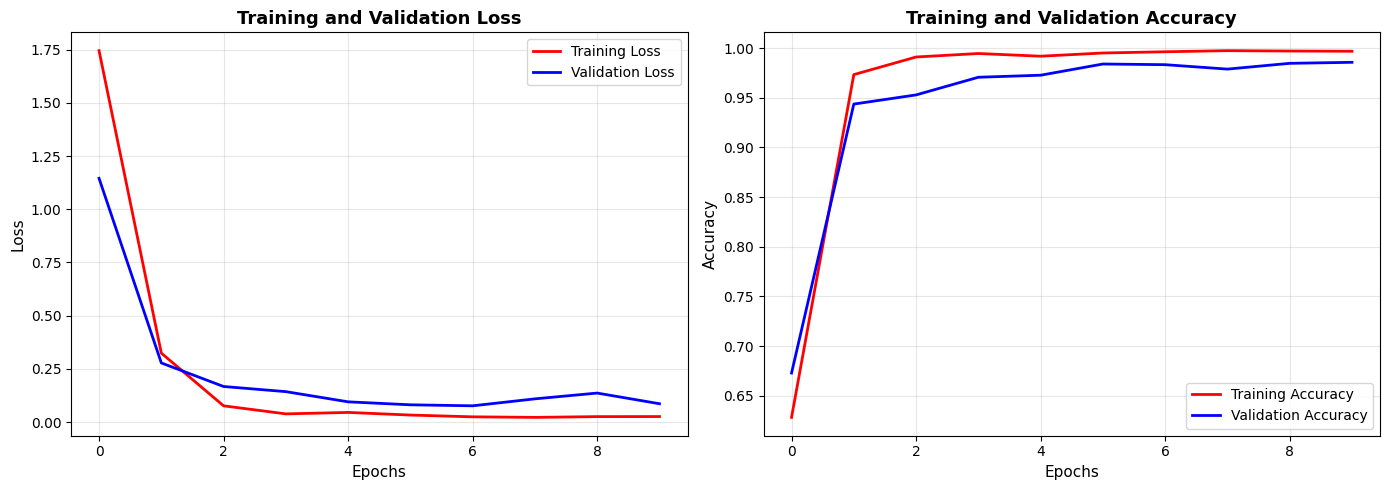

In [18]:
# Visualization training curves
plot_loss_and_accuracy_curves(gru_model_history)

In [19]:
# Đánh giá validation set

print("-"*50)
print("Validation set evaluation")

# Tạo predictions
val_probs = gru_model.predict(X_val_tensor, verbose=0)
val_preds = np.round(val_probs.flatten())

# Tính toán metrics
val_metrics = calculate_results(y_val.values, val_preds)
val_additional_metrics = calculate_metrics(y_val.values, val_preds)
val_auc = roc_auc_score(y_val.values, val_probs.flatten())

print("\n[Validation metrics]")
for key, value in val_metrics.items():
    print(f"  {key:12s}: {value:.4f}")
print(f"  {'AUC':12s}: {val_auc:.4f}")

print("\n[Additional metrics]")
for key, value in val_additional_metrics.items():
    print(f"  {key:30s}: {value:.4f}")

--------------------------------------------------
Validation set evaluation

[Validation metrics]
  accuracy    : 0.9832
  precision   : 0.9833
  recall      : 0.9832
  f1          : 0.9832
  AUC         : 0.9979

[Additional metrics]
  False Discovery Rate (FDR)    : 0.0148
  False Negative Rate (FNR)     : 0.0196
  False Omission Rate (FOR)     : 0.0186
  False Positive Rate (FPR)     : 0.0140
  Negative Prediction Value (NPV): 0.9814


Saved confusion matrix to: /content/drive/MyDrive/Colab Notebooks/DL-in-detecting-email-with-fake-content/outputs/models/GRU/confusion_matrix_val.png


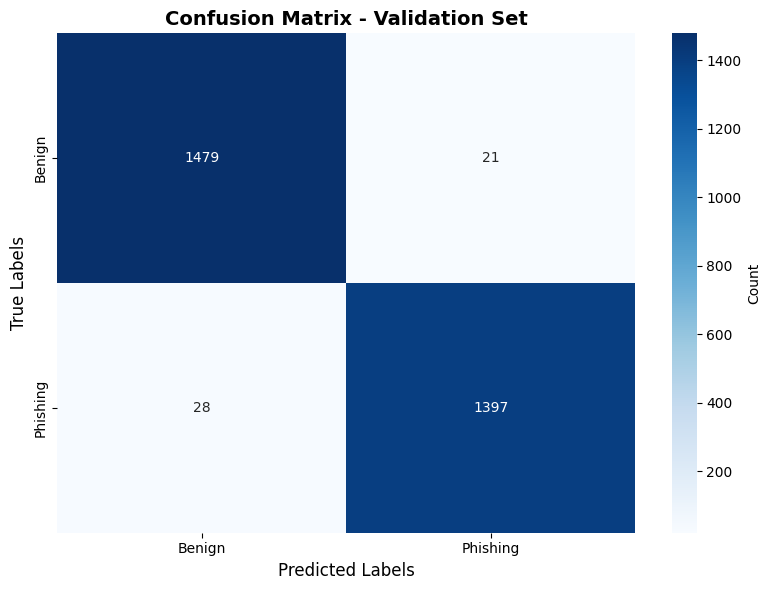

In [20]:
# Confusion matrix cho validation set
plot_confusion_matrix(
    y_true=y_val.values,
    y_pred=val_preds,
    class_names=["Benign", "Phishing"],
    title="Confusion Matrix - Validation Set",
    save_path=f'{BASE_PATH}/outputs/models/GRU/confusion_matrix_val.png'
)

Saved ROC curve to: /content/drive/MyDrive/Colab Notebooks/DL-in-detecting-email-with-fake-content/outputs/models/GRU/roc_curve_val.png


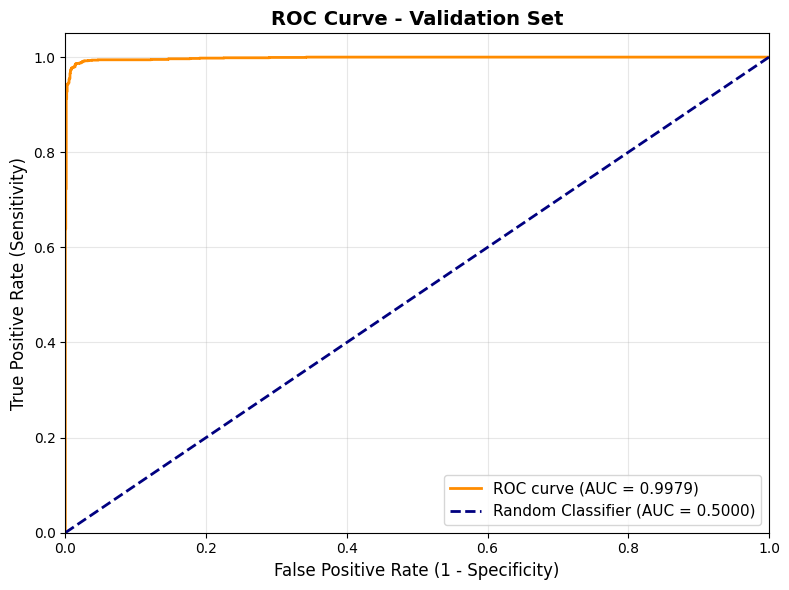


Validation AUC Score: 0.9979


In [21]:
# Roc curve cho validation set
val_auc_score, val_fpr, val_tpr = plot_roc_curve(
    y_true=y_val.values,
    y_probs=val_probs.flatten(),
    set_name="Validation",
    save_path=f'{BASE_PATH}/outputs/models/GRU/roc_curve_val.png'
)
print(f"\nValidation AUC Score: {val_auc_score:.4f}")

## 13. Đánh Giá Model trên Test Set


In [22]:
# Đánh giá test set

print("-"*50)
print("Test set evaluation")

# Chuẩn bị dữ liệu test
test_text_processed = X_test.fillna('').astype(str)
test_text_tensor = tf.constant(test_text_processed.values, dtype=tf.string)

# Tạo predictions
pred_labels_gru = gru_model.predict(test_text_tensor, verbose=0)
test_probs = pred_labels_gru.flatten()
test_preds = np.round(test_probs)

print(f"Test samples: {len(test_text_tensor)}")
print(f"Predictions completed")

--------------------------------------------------
Test set evaluation
Test samples: 2925
Predictions completed


In [23]:
# Tính toán metrics
gru_test_metrics = calculate_results(y_test.values, test_preds)
gru_test_additional_metrics = calculate_metrics(y_test.values, test_preds)
test_auc = roc_auc_score(y_test.values, test_probs)

print("\n[Test metrics]")
for key, value in gru_test_metrics.items():
    print(f"  {key:12s}: {value:.4f}")
print(f"  {'AUC':12s}: {test_auc:.4f}")

print("\n[Additional metrics]")
for key, value in gru_test_additional_metrics.items():
    print(f"  {key:30s}: {value:.4f}")


[Test metrics]
  accuracy    : 0.9856
  precision   : 0.9856
  recall      : 0.9856
  f1          : 0.9856
  AUC         : 0.9976

[Additional metrics]
  False Discovery Rate (FDR)    : 0.0134
  False Negative Rate (FNR)     : 0.0161
  False Omission Rate (FOR)     : 0.0153
  False Positive Rate (FPR)     : 0.0127
  Negative Prediction Value (NPV): 0.9847


In [24]:
# Classification report
print("\n" + "-"*50)
print("Classification report - Test set")
print("-"*50)
report = classification_report(y_test.values, test_preds,
                               target_names=['Benign', 'Phishing'])
print(report)


--------------------------------------------------
Classification report - Test set
--------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.98      0.99      0.99      1500
    Phishing       0.99      0.98      0.99      1425

    accuracy                           0.99      2925
   macro avg       0.99      0.99      0.99      2925
weighted avg       0.99      0.99      0.99      2925



Saved confusion matrix to: /content/drive/MyDrive/Colab Notebooks/DL-in-detecting-email-with-fake-content/outputs/models/GRU/confusion_matrix_test.png


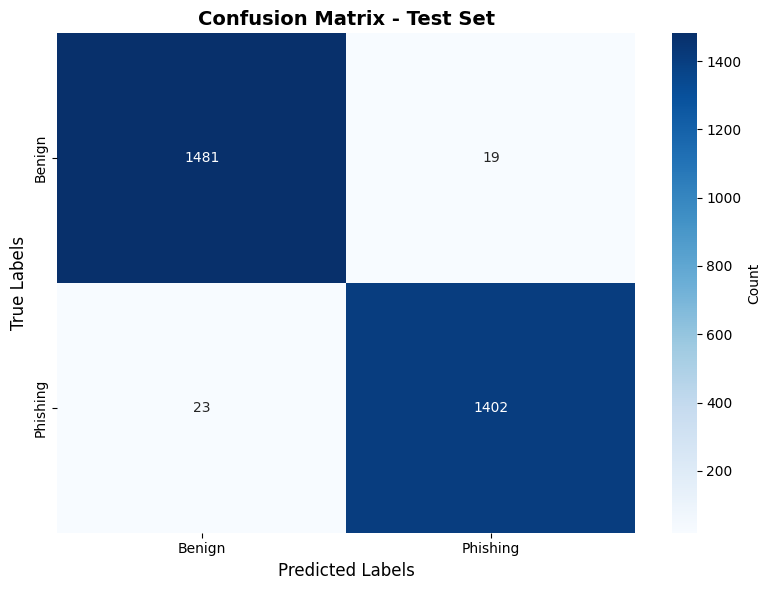

In [25]:
# Confusion matrix cho test set
plot_confusion_matrix(
    y_true=y_test.values,
    y_pred=test_preds,
    class_names=["Benign", "Phishing"],
    title="Confusion Matrix - Test Set",
    save_path=f'{BASE_PATH}/outputs/models/GRU/confusion_matrix_test.png'
)

Saved ROC curve to: /content/drive/MyDrive/Colab Notebooks/DL-in-detecting-email-with-fake-content/outputs/models/GRU/roc_curve_test.png


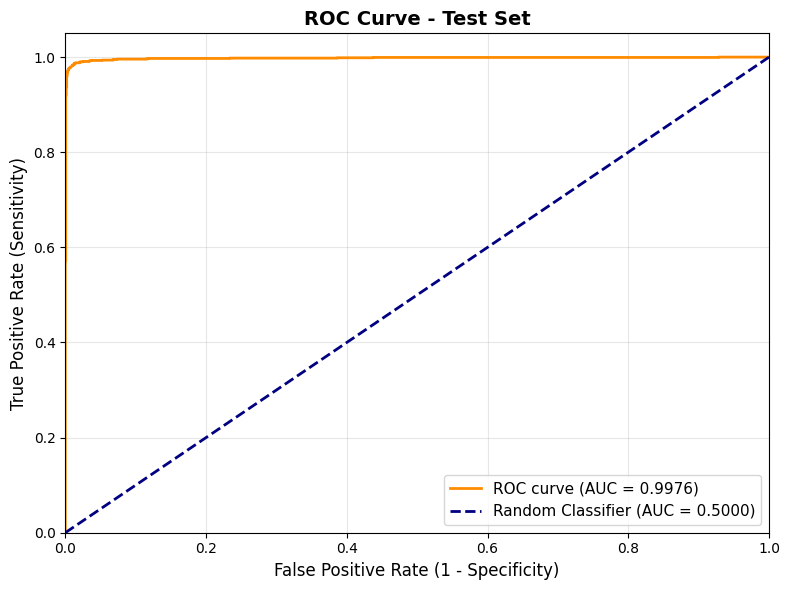


Test AUC Score: 0.9976


In [26]:
# Roc curve cho test set
test_auc_score, test_fpr, test_tpr = plot_roc_curve(
    y_true=y_test.values,
    y_probs=test_probs,
    set_name="Test",
    save_path=f'{BASE_PATH}/outputs/models/GRU/roc_curve_test.png'
)
print(f"\nTest AUC Score: {test_auc_score:.4f}")

## 14. Tổng Hợp Kết Quả cho Tất Cả Sets


In [27]:
# Đánh giá toàn diện - tất cả sets

print("-"*50)
print("Tổng hợp kết quả - tất cả sets")

# Tính toán metrics cho train set
train_probs = gru_model.predict(X_train_tensor, verbose=0)
train_preds = np.round(train_probs.flatten())
gru_train_metrics = calculate_results(y_train.values, train_preds)
gru_train_additional = calculate_metrics(y_train.values, train_preds)
train_auc = roc_auc_score(y_train.values, train_probs.flatten())

# Validation metrics (đã tính toán): val_metrics, val_additional_metrics, val_auc

# Test metrics (đã tính toán): gru_test_metrics, gru_test_additional_metrics, test_auc

# In summary
print("\n[Train set]")
for key, value in gru_train_metrics.items():
    print(f"  {key:12s}: {value:.4f}")
print(f"  {'AUC':12s}: {train_auc:.4f}")

print("\n[Validation set]")
for key, value in val_metrics.items():
    print(f"  {key:12s}: {value:.4f}")
print(f"  {'AUC':12s}: {val_auc:.4f}")

print("\n[Test set]")
for key, value in gru_test_metrics.items():
    print(f"  {key:12s}: {value:.4f}")
print(f"  {'AUC':12s}: {test_auc:.4f}")

--------------------------------------------------
Tổng hợp kết quả - tất cả sets

[Train set]
  accuracy    : 0.9979
  precision   : 0.9979
  recall      : 0.9979
  f1          : 0.9979
  AUC         : 1.0000

[Validation set]
  accuracy    : 0.9832
  precision   : 0.9833
  recall      : 0.9832
  f1          : 0.9832
  AUC         : 0.9979

[Test set]
  accuracy    : 0.9856
  precision   : 0.9856
  recall      : 0.9856
  f1          : 0.9856
  AUC         : 0.9976



--------------------------------------------------
ROC Curves Comparison - All Sets
Saved ROC curves comparison to: /content/drive/MyDrive/Colab Notebooks/DL-in-detecting-email-with-fake-content/outputs/models/GRU/roc_curves_comparison.png


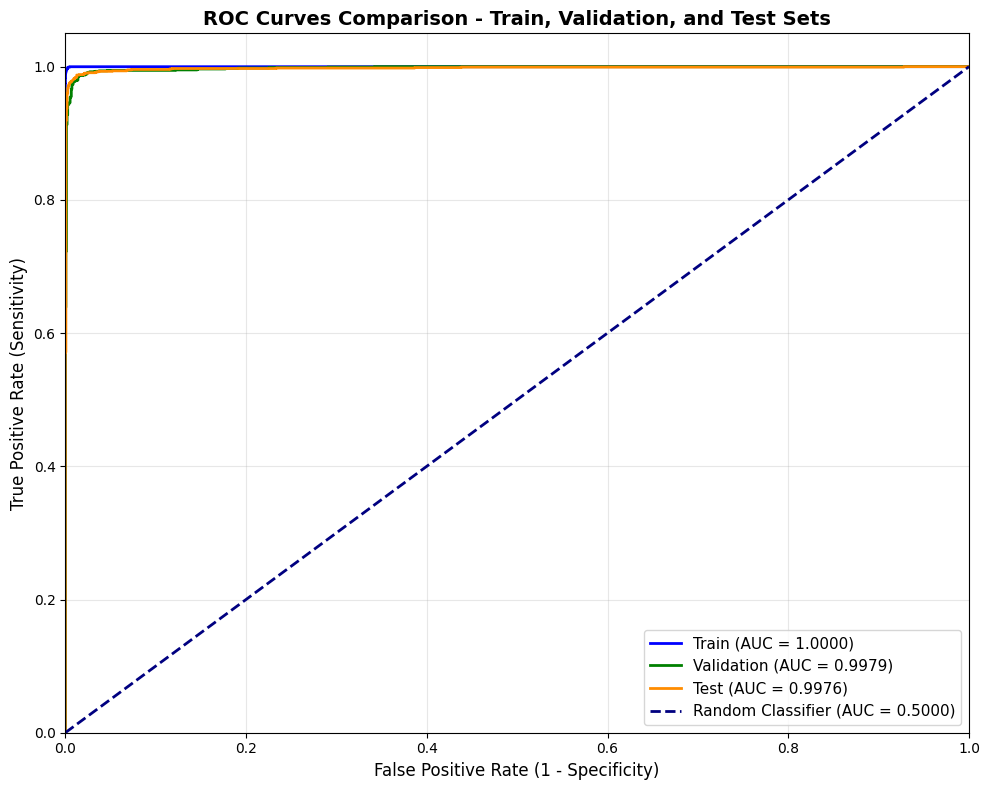

In [28]:
# So sánh roc curves - tất cả sets
print("\n" + "-"*50)
print("ROC Curves Comparison - All Sets")

# Tính toán roc curves
train_fpr, train_tpr, _ = roc_curve(y_train.values, train_probs.flatten())
val_fpr, val_tpr, _ = roc_curve(y_val.values, val_probs.flatten())
test_fpr, test_tpr, _ = roc_curve(y_test.values, test_probs)

# Vẽ so sánh
plt.figure(figsize=(10, 8))
plt.plot(train_fpr, train_tpr, color='blue', lw=2,
         label=f'Train (AUC = {train_auc:.4f})')
plt.plot(val_fpr, val_tpr, color='green', lw=2,
         label=f'Validation (AUC = {val_auc:.4f})')
plt.plot(test_fpr, test_tpr, color='darkorange', lw=2,
         label=f'Test (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Curves Comparison - Train, Validation, and Test Sets',
          fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{BASE_PATH}/outputs/models/GRU/roc_curves_comparison.png',
            dpi=300, bbox_inches='tight')
print(f"Saved ROC curves comparison to: {BASE_PATH}/outputs/models/GRU/roc_curves_comparison.png")
plt.show()

## 15. Lưu Model và Vocabulary


In [29]:
# Lưu model và vocabulary

print("-"*50)
print("Lưu model và vocabulary")

# Lưu model
gru_model.save(f'{BASE_PATH}/outputs/models/GRU/gru_model.h5')
print(f"Saved model: {BASE_PATH}/outputs/models/GRU/gru_model.h5")

# Lưu vocabulary (quan trọng: cần để reload model sau này)
vocab_to_save = text_vectorizer.get_vocabulary()
vocab_file = f"{BASE_PATH}/outputs/models/GRU/gru_embedding_metadata.tsv"
with io.open(vocab_file, "w", encoding="utf-8") as f:
    for word in vocab_to_save:
        f.write(str(word) + "\n")
print(f"Saved vocabulary: {vocab_file}")
print(f"Vocabulary size: {len(vocab_to_save)} tokens")

--------------------------------------------------
Lưu model và vocabulary
Saved model: /content/drive/MyDrive/Colab Notebooks/DL-in-detecting-email-with-fake-content/outputs/models/GRU/gru_model.h5
Saved vocabulary: /content/drive/MyDrive/Colab Notebooks/DL-in-detecting-email-with-fake-content/outputs/models/GRU/gru_embedding_metadata.tsv
Vocabulary size: 20000 tokens


## 16. Lưu Kết Quả Đánh Giá vào JSON


In [30]:
# Lưu metrics vào json

gru_metrics = {
    'model_config': {
        'model': 'GRU',
        'embedding_dim': gru_model_embedding.output_dim,
        'vocab_size': text_vectorizer.get_config()['max_tokens'],
        'max_len': text_vectorizer.get_config()['output_sequence_length'],
        'epochs_trained': len(gru_model_history.history['loss']),
        'actual_vocab_size': len(words_in_vocab)
    },
    'train_evaluation': {
        'accuracy': round(gru_train_metrics['accuracy'], 4),
        'f1_score': round(gru_train_metrics['f1'], 4),
        'precision': round(gru_train_metrics['precision'], 4),
        'recall': round(gru_train_metrics['recall'], 4),
        'auc': round(train_auc, 4),
        'False Discovery Rate (FDR)': round(gru_train_additional['False Discovery Rate (FDR)'], 4),
        'False Negative Rate (FNR)': round(gru_train_additional['False Negative Rate (FNR)'], 4),
        'False Omission Rate (FOR)': round(gru_train_additional['False Omission Rate (FOR)'], 4),
        'False Positive Rate (FPR)': round(gru_train_additional['False Positive Rate (FPR)'], 4),
        'Negative Prediction Value (NPV)': round(gru_train_additional['Negative Prediction Value (NPV)'], 4)
    },
    'validation_evaluation': {
        'accuracy': round(val_metrics['accuracy'], 4),
        'f1_score': round(val_metrics['f1'], 4),
        'precision': round(val_metrics['precision'], 4),
        'recall': round(val_metrics['recall'], 4),
        'auc': round(val_auc, 4),
        'False Discovery Rate (FDR)': round(val_additional_metrics['False Discovery Rate (FDR)'], 4),
        'False Negative Rate (FNR)': round(val_additional_metrics['False Negative Rate (FNR)'], 4),
        'False Omission Rate (FOR)': round(val_additional_metrics['False Omission Rate (FOR)'], 4),
        'False Positive Rate (FPR)': round(val_additional_metrics['False Positive Rate (FPR)'], 4),
        'Negative Prediction Value (NPV)': round(val_additional_metrics['Negative Prediction Value (NPV)'], 4)
    },
    'test_evaluation': {
        'accuracy': round(gru_test_metrics['accuracy'], 4),
        'f1_score': round(gru_test_metrics['f1'], 4),
        'precision': round(gru_test_metrics['precision'], 4),
        'recall': round(gru_test_metrics['recall'], 4),
        'auc': round(test_auc, 4),
        'False Discovery Rate (FDR)': round(gru_test_additional_metrics['False Discovery Rate (FDR)'], 4),
        'False Negative Rate (FNR)': round(gru_test_additional_metrics['False Negative Rate (FNR)'], 4),
        'False Omission Rate (FOR)': round(gru_test_additional_metrics['False Omission Rate (FOR)'], 4),
        'False Positive Rate (FPR)': round(gru_test_additional_metrics['False Positive Rate (FPR)'], 4),
        'Negative Prediction Value (NPV)': round(gru_test_additional_metrics['Negative Prediction Value (NPV)'], 4)
    }
}

# Lưu vào json
metrics_file = f"{BASE_PATH}/outputs/models/GRU/gru_metrics.json"
with open(metrics_file, "w", encoding='utf-8') as f:
    json.dump(gru_metrics, f, indent=4, ensure_ascii=False)

print("-"*50)
print("Đã lưu kết quả")
print(f"Metrics saved to: {metrics_file}")
print(f"Model saved to: {BASE_PATH}/outputs/models/GRU/gru_model.h5")
print(f"Vocabulary saved to: {BASE_PATH}/outputs/models/GRU/gru_embedding_metadata.tsv")
print(f"Confusion matrices saved")
print(f"ROC curves saved")

--------------------------------------------------
Đã lưu kết quả
Metrics saved to: /content/drive/MyDrive/Colab Notebooks/DL-in-detecting-email-with-fake-content/outputs/models/GRU/gru_metrics.json
Model saved to: /content/drive/MyDrive/Colab Notebooks/DL-in-detecting-email-with-fake-content/outputs/models/GRU/gru_model.h5
Vocabulary saved to: /content/drive/MyDrive/Colab Notebooks/DL-in-detecting-email-with-fake-content/outputs/models/GRU/gru_embedding_metadata.tsv
Confusion matrices saved
ROC curves saved


## 18. Load Model và Vocabulary (Optional)

Load lại model đã lưu


In [31]:
# Load model từ file .h5
gru_model_loaded = tf.keras.models.load_model(f'{BASE_PATH}/outputs/models/GRU/gru_model.h5')
print('Loaded GRU model successfully from .h5 file')

# Quan trọng: re-initialize textvectorization vocabulary
# Vì file .h5 không lưu vocabulary của textvectorization layer
print('Re-initializing TextVectorization vocabulary...')

# Lấy textvectorization layer
text_vec_layer = gru_model_loaded.get_layer("text_vectorization")

# Lấy max_tokens từ layer config
layer_config = text_vec_layer.get_config()
max_tokens = layer_config.get('max_tokens', 20000)
print(f'Model max_tokens: {max_tokens}')

# Load vocabulary từ file metadata
vocab_file = f"{BASE_PATH}/outputs/models/GRU/gru_embedding_metadata.tsv"
with io.open(vocab_file, "r", encoding="utf-8") as f:
    words_from_file = [line.strip() for line in f if line.strip()]

# Textvectorization cần 2 tokens đặc biệt: '' (padding) và '[UNK]' (unknown)
num_words_to_take = max_tokens - 2
vocabulary = ['', '[UNK]'] + words_from_file[:num_words_to_take]

# Set vocabulary cho layer
text_vec_layer.set_vocabulary(vocabulary)
print(f'Re-initialized vocabulary with {len(vocabulary)} tokens')
print(f'Sample vocabulary: {vocabulary[:10]}')

# Sử dụng model đã load
gru_model = gru_model_loaded


Loaded GRU model successfully from .h5 file
Re-initializing TextVectorization vocabulary...
Model max_tokens: 20000
Re-initialized vocabulary with 20000 tokens
Sample vocabulary: ['', '[UNK]', '[UNK]', 'the', 'to', 'of', 'and', 'you', 'in', 'i']


In [32]:
# Predict trên email mới
# Tạo một số email mẫu để test
new_emails = [
    "Internal HR Data Alignment Notice. This message is part of our quarterly internal alignment initiative focused on ensuring consistency across employee records following recent system integrations. As several tools were consolidated (time tracking, internal directory, notification preferences), we identified that a subset of profiles may show partial mismatches due to legacy formatting or delayed synchronization. This is not a corrective action and does not imply an issue with your account. However, to prevent potential delays in access provisioning or automated approvals, employees are asked to complete a brief self-review. The review confirms that basic profile attributes—such as display name, team affiliation, internal contact reference, and notification routing—are still accurate. The process is intentionally lightweight and should take no more than a few minutes. If no changes are required, you can simply confirm the current state. If updates are needed, you may annotate them directly so the system can reconcile differences without creating a support ticket. To proceed, please access the internal portal at [PORTAL], navigate to Profile Review, and complete the highlighted sections. Once reviewed, select [ACTION] to submit confirmation. If your profile has already been verified recently, the system will automatically mark it as complete and no further steps will be required. Please note that unconfirmed profiles may temporarily be placed into a pending state as part of automated compliance checks. This does not restrict general access but may delay role-specific permissions until reconciliation is complete. If you encounter any difficulties or believe this notice was sent in error, feel free to reply to this message so we can assist promptly. Thank you for helping us maintain accurate internal records.",
    "Logistics Intake Confirmation Hello, The office intake desk has received an item that appears to be associated with an internal shipment but lacks a complete recipient record. The label includes an abbreviated name and internal reference code, which matches multiple profiles. To prevent misrouting or automatic return, we are contacting potential recipients to confirm ownership. This is a standard procedure for unidentified deliveries and does not indicate any issue. If you are expecting equipment, documents, or materials, please confirm whether this item belongs to you. Confirmation requires only minimal information to route the package correctly. Visit [OFFICE_PORTAL], navigate to Deliveries, enter reference [ID], and select [ACTION]. If the item is not yours, you may select “Not my delivery,” and the system will continue matching. Items without confirmation are held for a limited time per policy before being returned to the sender. We apologize for the interruption and appreciate your quick response to help resolve the intake efficiently.",
    "IT Security Verification (Policy-Compliant Language) Hello, As part of our ongoing security posture review, the IT team is conducting a controlled verification of account metadata following recent environment updates. This review focuses on identifying benign anomalies such as new browser fingerprints, network changes, or device reconfigurations that can trigger precautionary flags. Your account was included in this review due to a non-critical change pattern detected last week. This does not indicate unauthorized activity. The verification process simply ensures the system correctly associates recent activity with a trusted user context. No information is collected via email. The only required step is to access the internal security console and confirm the listed device and session attributes. If the information matches your usage, the verification will complete immediately. Please visit [SECURITY_PORTAL], open Session Review, and follow the on-screen instructions. Once complete, select [ACTION] to finalize. If the review is not completed within the verification window, the system may temporarily limit certain sensitive operations (such as privilege elevation or environment exports) until confirmation is received. If you have already completed a similar check recently, the portal will reflect a completed status and no further action is required. For questions or access issues, reply to this message so we can assist. Thank you for helping maintain a secure and reliable environment.",
    "Shared Documentation Access Normalization Hello, We are in the process of consolidating shared project documentation into a standardized structure to reduce duplication and ensure everyone is referencing the most current materials. As part of this effort, legacy permissions are being reviewed and normalized. During this transition, some users may notice that previously accessible documents now appear with a “request access” status. This is expected behavior while roles are revalidated against the updated access model. To streamline this process and avoid manual requests, we are asking users to confirm their current role and access level. This allows the system to automatically assign appropriate permissions without over-provisioning, which is required for audit compliance. Please go to [PORTAL], select Access Review, verify your role within the relevant project space, and submit using [ACTION]. If your role does not require edit permissions, selecting view-only will still ensure uninterrupted access. If you believe your access has been incorrectly restricted or if you require temporary elevated access, respond to this email and we will review it manually. Our goal is to complete this normalization quickly so everyone can continue working without disruption.",
    "Billing Clarification and Cost Attribution Review Hello, We are reaching out as part of the routine end-of-cycle reconciliation for operational expenses. During aggregation, a small number of entries were flagged due to missing or ambiguous cost attribution tags. This is common when services are renewed, reclassified, or split across initiatives. Your name appears as the reference contact for one of the affected entries. This does not indicate an error; it simply means the system requires confirmation to finalize allocation and prevent the item from being deferred to the next reporting period. To simplify the process, we have prepared a summarized view that excludes sensitive payment details and focuses only on descriptive fields: service category, usage window, project reference, and cost center. If the information appears correct, you may approve it directly. If adjustments are required, selecting the adjustment option will allow you to leave a brief clarification note. Please log into [PORTAL], open Billing Review, locate reference [ID], and select [ACTION] to complete the confirmation. If no action is taken before the cycle closes, the item may temporarily remain pending, which could affect monthly summaries but will not impact approvals already granted. We understand end-of-period workloads can be heavy, so this message is intended to provide context and reduce follow-up. Let us know if you need assistance or if this reference should be reassigned.",
    "Security Training Simulation Announcement Hello PTITer, This week we are running a scheduled security awareness simulation designed to improve recognition of suspicious messages and reduce response time to potential threats. As part of the exercise, participants may receive simulated emails that resemble phishing attempts, including urgent language or verification prompts. Please be aware that these messages are part of a controlled training environment. They will not contain real links, credential requests, or data collection mechanisms. The purpose is to evaluate decision-making and reporting behavior, not to test compliance through deception. If you receive a simulation message, do not follow the instructions in the ",
    "Research Consent Email (Contains Sensitive Vocabulary) Hello, You are invited to participate in an internal research study examining how users interpret system notifications that reference identity verification, account confirmation, or credential-related terminology. These terms are used descriptively within hypothetical scenarios and do not require you to provide real credentials at any point.The study has been reviewed and approved through the appropriate ethics process. Participation is voluntary, and all responses are anonymized. You may stop at any time without penalty.During the study, you will review example messages and indicate how you would respond. Some messages intentionally include language often associated with phishing to evaluate perception and awareness. If you agree to participate, please visit [RESEARCH_PORTAL] and indicate consent. If you prefer not to participate, you may ignore this message.",
    "Password Reset Training Module Hello, As part of mandatory onboarding training, you will complete a module that demonstrates common password reset workflows. The module includes simulated login screens and reset prompts to illustrate how legitimate systems differ from malicious ones. Do not enter real credentials during training. All inputs use mock data and exist solely within the learning environment. To begin, visit [TRAINING_PORTAL] and open the Account Safety module. Completion will be automatically recorded.",
    "Finance Reminder with “Urgent” Terminology Hello, This is a required reminder regarding an outstanding receipt confirmation associated with a previously approved expense. System templates label this notice as “urgent” to ensure timely processing before the reporting window closes. No payment details or login information are requested. The confirmation simply verifies that services or goods were received as recorded. Please access [BILLING_PORTAL], locate the pending item, and submit confirmation. If you are not the correct contact, forwarding this message to the appropriate party will help avoid delays. We appreciate your attention to this administrative requirement.",
    "QA Report Discussing Phishing Data Hello team, Attached is this week’s QA summary covering dataset quality for email classification tasks. The report includes analysis of phishing indicators, credential language, and attack-style phrasing found in sample data. These references describe dataset content only and do not represent real incidents. The goal is to improve model robustness by understanding why certain benign emails are misclassified and vice versa. Please review and share any observations that could help refine preprocessing or labeling standards.",
]

# Quan trọng: preprocess emails trước khi predict (giữ nguyên stopwords)
new_emails_processed = [email for email in new_emails]

# Chuyển đổi sang tensor
new_emails_tensor = tf.convert_to_tensor(new_emails_processed, dtype=tf.string)

# Tạo predictions
predictions = gru_model.predict(new_emails_tensor, verbose=0)
binary_predictions = (predictions > 0.5).astype(int)

# Hiển thị kết quả
print("-"*50)
print("PREDICTION RESULTS - NEW EMAILS")
for i, email in enumerate(new_emails, 1):
    label = 'Phishing' if binary_predictions[i-1][0] == 1 else 'Benign'
    prob = predictions[i-1][0]
    print(f"\nEmail {i}:")
    print(f"  Text: {email[:80]}...")
    print(f"  Predicted: {label} (Probability: {prob:.4f})")


--------------------------------------------------
PREDICTION RESULTS - NEW EMAILS

Email 1:
  Text: Internal HR Data Alignment Notice. This message is part of our quarterly interna...
  Predicted: Phishing (Probability: 0.7816)

Email 2:
  Text: Logistics Intake Confirmation Hello, The office intake desk has received an item...
  Predicted: Phishing (Probability: 0.9778)

Email 3:
  Text: IT Security Verification (Policy-Compliant Language) Hello, As part of our ongoi...
  Predicted: Phishing (Probability: 0.9862)

Email 4:
  Text: Shared Documentation Access Normalization Hello, We are in the process of consol...
  Predicted: Phishing (Probability: 0.6941)

Email 5:
  Text: Billing Clarification and Cost Attribution Review Hello, We are reaching out as ...
  Predicted: Phishing (Probability: 0.9270)

Email 6:
  Text: Security Training Simulation Announcement Hello PTITer, This week we are running...
  Predicted: Benign (Probability: 0.0014)

Email 7:
  Text: Research Consent Email (C